# Product recommendation system based on  sentiment Analysis of the product Reviews

The sentiment analysis  is a natural language processing technique used to determine the sentiment or emotional tone expressed in a piece of text such as review,social media post or article etc. The primary goal of sentiment analysis is to classify the given text of  review as positive or negative or neutral. Further,  The recommendation system is created which recommend the list of the brands of products according to their  sentiment of reviews. The sentiment analysis is done by using the BERT and recommendation system is created using machine learning algorithms.

BERT is an NLP model developed by google research in 2018, after its inception it has achieved state-of-the-art accuracy on several Natural language processing tasks.

In [46]:
#importing all the dependencies that  we  gonna use to implement the sentiment analysis and recommendation system.



In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import nltk
nltk.download('punkt')
import re , spacy, string
nlp   = spacy.load('en_core_web_sm',disable=["parser","ner"])
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

#importing other missing library for  handling the warnings
import warnings
warnings.filterwarnings('ignore')


/Users/ramesh/Desktop/System Recommendation/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/ramesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Setting initial variables and constant with device setup as well
#setting initial variable and constants
%config InlineBackend.figure_format='retina'

#Graph desigining for visualization of the data in different graphs
sns.set(style ='whitegrid',palette ='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
#setting the  color palettes for the sns vusualizations
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] =12,8

#Random seed for reproduciability
RANDOM_SEED =42
np.random.seed(RANDOM_SEED)
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
#assert num_gpus_available > 0


Num GPUs Available:  0


##Importing the  dataset

The dataset of product review is collected from the kaggle and modiflied.

In [5]:
data  = pd.read_csv("/Users/ramesh/Desktop/System Recommendation/model/sample30.csv")

In [6]:
# structures of the dataset and the all the features that we found in the data are
data.head(10)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things...,Not worth it,NaN,NaN,samantha
6,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,False,1,Bought this earlier today and was excited to c...,Disappointing,NaN,NaN,raeanne
7,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,False,1,I bought this product for my husband and I to ...,Not happy at all,NaN,NaN,kimmie
8,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-28T00:00:00.000Z,False,False,1,My husband and I bought this for some extra fu...,Very disappointing,NaN,NaN,cassie
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-21T00:00:00.000Z,False,False,1,Got as a surprise for my husband there is noth...,Don't buy,NaN,NaN,moore222


In [7]:
#all the features of the data are given by
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
dtypes: int64(1), object(13)
memory usage: 3.2+ MB


The given dataset contain 13 feature which are
1. id
2. brand
3. categories
4. name
5. manufacturer
6. review_date
7. review_didPurchase
8. review_doRecommend
9. review_rating
10. reivew_text
11. review_title
12. review_usercity
13. reveiew_userprovince
14. review_username

In [8]:
# lets look on the initial size of the dataset
data.shape


(30000, 14)

In [9]:
# data is too long and takes long time to run the code so we are removing the some of the records and 
n = 26000
data.drop(data.tail(n).index,inplace=True)

## Data cleaning

In [10]:
# we do not need all the features of the given dataset so we need to drop some features and create the  new dataset
data   =data[["brand","name","categories","reviews_username","reviews_rating","reviews_text"]]

In [11]:
#new data that we are going to use for sentiment analysis is
data.head(10)

,brand,name,categories,reviews_username,reviews_rating,reviews_text
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",joshua,5,i love this album. it's very good. more to the...
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,5,Good flavor. This review was collected as part...
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,5,Good flavor.
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",rebecca,1,I read through the reviews on here before look...
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",walker557,1,My husband bought this gel for us. The gel cau...
5,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",samantha,1,My boyfriend and I bought this to spice things...
6,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",raeanne,1,Bought this earlier today and was excited to c...
7,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",kimmie,1,I bought this product for my husband and I to ...
8,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",cassie,1,My husband and I bought this for some extra fu...
9,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",moore222,1,Got as a surprise for my husband there is noth...


In [12]:
#HANDLING THE MISSING VALUES
data.isnull().sum()

brand               0
name                0
categories          0
reviews_username    7
reviews_rating      0
reviews_text        0
dtype: int64

In [13]:
# we have the some username values ar emissing  here so we gonna remove these rows of data.
data =data[~ data.reviews_username.isna()]

In [14]:
data.head()

,brand,name,categories,reviews_username,reviews_rating,reviews_text
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",joshua,5,i love this album. it's very good. more to the...
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,5,Good flavor. This review was collected as part...
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,5,Good flavor.
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",rebecca,1,I read through the reviews on here before look...
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",walker557,1,My husband bought this gel for us. The gel cau...


In [15]:
#converting the rating of review into the sentiment and analyze it
data['sentiment'] =data['reviews_rating'].apply(lambda score: "positive" if score> 3 else "negative")
#here we are neglecting the neutral score as which  is not quite useful for recommending the product  accordingto
#sentiment analysis so

data["sentiment"]= data['sentiment'].map({"positive":1 , "negative":0})

In [16]:
data  = data[['brand',"name","categories","reviews_username",'reviews_text','sentiment']]

In [17]:
data.head()

,brand,name,categories,reviews_username,reviews_text,sentiment
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",joshua,i love this album. it's very good. more to the...,1
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,Good flavor. This review was collected as part...,1
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,Good flavor.,1
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",rebecca,I read through the reviews on here before look...,0
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",walker557,My husband bought this gel for us. The gel cau...,0


In [18]:
data.isnull().sum()


brand               0
name                0
categories          0
reviews_username    0
reviews_text        0
sentiment           0
dtype: int64

In [19]:
data.shape

(3993, 6)

In [20]:
#handling the punctuation of the text   of the text review
#function to  clean the text and remove all the  unnecessary elements
def clean_punctuation(sent):
    sent  =sent.lower()
    pattern = '[^\w\s]'# removing punctuation
    sent  =re.sub(pattern, '',sent)
    return sent

In [21]:
#applying the   cleaning  punctuation function
data['reviews_text']=data['reviews_text'].apply(clean_punctuation)

In [22]:
data.head()

,brand,name,categories,reviews_username,reviews_text,sentiment
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",joshua,i love this album its very good more to the hi...,1
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,good flavor this review was collected as part ...,1
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,good flavor,1
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",rebecca,i read through the reviews on here before look...,0
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",walker557,my husband bought this gel for us the gel caus...,0


##HANDLING STOPWORDS

In [23]:
stopwords_set  = set(stopwords.words('english'))
print(stopwords_set)

{'been', 'wouldn', 'now', 'further', 'which', 'isn', 'under', "she's", 'it', 'whom', 'where', 'weren', 's', 'this', 'over', 'yours', "didn't", 've', "mightn't", 'from', "isn't", 'should', 'doesn', 'an', 'no', 'so', 'himself', 'or', 'before', 'their', 'does', 'because', "needn't", 'had', 'any', 'do', 'me', 'needn', 'did', 'during', 'our', 'through', 'off', 'above', 'yourself', 'between', 'just', 'we', 't', 'o', "you'll", 'out', 'doing', 'herself', 'didn', 'were', 'but', 'of', 'myself', 'not', 'these', 'd', 'ain', "wouldn't", "couldn't", 'shan', 'most', 'they', 'that', 'about', 'both', 'mightn', 'my', 'here', 'how', 'there', 'after', 'other', 'her', 'are', 'am', 'its', "aren't", 'and', 'aren', 'who', 'by', 'in', 'to', 'down', 'them', "don't", "hasn't", 'very', 'until', 'ours', 'm', 'themselves', 'few', "won't", 'hadn', "you'd", 'for', 'nor', 'some', 'a', 'couldn', 'he', 'won', 'yourselves', 'you', 'be', 'same', 'y', 'all', 'll', 'up', 'being', "that'll", 'against', 'at', 'mustn', 'hasn',

In [24]:
# creating the function to remove the stopwords
def clean_stopwords(sent):
    """The function clean the stops words in the  text sentences."""
    sent  =sent.lower() # text to lowercase
    words = word_tokenize(sent)# split the sentence into words
    text_nostopwords  = " ".join([each_word for each_word in words if each_word not in stopwords_set])
    return sent

In [31]:
#aply the function of removing the stop words
data['reviews_text'] =data['reviews_text'].apply(clean_stopwords)

In [25]:
data.head()

,brand,name,categories,reviews_username,reviews_text,sentiment
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",joshua,i love this album its very good more to the hi...,1
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,good flavor this review was collected as part ...,1
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,good flavor,1
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",rebecca,i read through the reviews on here before look...,0
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",walker557,my husband bought this gel for us the gel caus...,0


## handling  lammentization


In [26]:
#function to lemmentize the text
def clean_lemma(text):
    sent  = [ ]
    document  = nlp(text)
    for token in document:
        sent.append(token.lemma_)
    return " ".join(sent)

In [27]:
data['lemma_text'] =data['reviews_text'].apply(clean_lemma)

In [28]:
data.head()

,brand,name,categories,reviews_username,reviews_text,sentiment,lemma_text
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",joshua,i love this album its very good more to the hi...,1,I love this album its very good more to the hi...
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,good flavor this review was collected as part ...,1,good flavor this review be collect as part of ...
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,good flavor,1,good flavor
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",rebecca,i read through the reviews on here before look...,0,I read through the review on here before look ...
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",walker557,my husband bought this gel for us the gel caus...,0,my husband buy this gel for we the gel cause i...


In [29]:
#now we donot need the review text as we have lamentized text
data.drop('reviews_text', axis=1)

,brand,name,categories,reviews_username,sentiment,lemma_text
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",joshua,1,I love this album its very good more to the hi...
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,1,good flavor this review be collect as part of ...
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,1,good flavor
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",rebecca,0,I read through the review on here before look ...
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",walker557,0,my husband buy this gel for we the gel cause i...
...,...,...,...,...,...,...
3995,Pendaflex,"Pendaflex174 Divide It Up File Folder, Multi S...","School & Office Supplies,Filing,Files,File Fol...",kathie,1,this product be great for file my credit card ...
3996,Pendaflex,"Pendaflex174 Divide It Up File Folder, Multi S...","School & Office Supplies,Filing,Files,File Fol...",diana,1,I love that I can put more than one type of fo...
3997,Pendaflex,"Pendaflex174 Divide It Up File Folder, Multi S...","School & Office Supplies,Filing,Files,File Fol...",jessie booters,1,I use this product to organize financial and p...
3998,Pendaflex,"Pendaflex174 Divide It Up File Folder, Multi S...","School & Office Supplies,Filing,Files,File Fol...",anne,1,as a small business owner this really help org...


In [34]:
cdata  = data.to_csv("/Users/ramesh/Desktop/System Recommendation/model/cdata.csv",index=False)

## Visualization and Distribution of the data

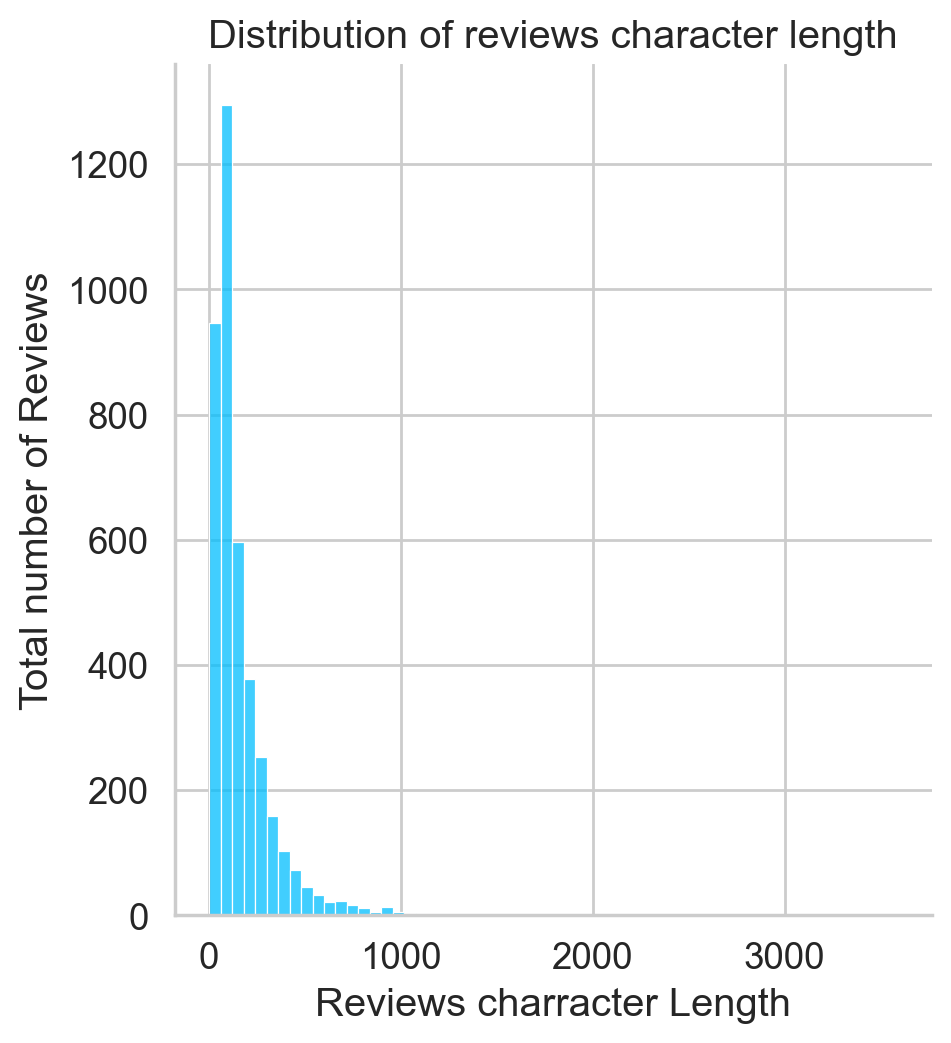

In [75]:
# visualizing the distribution of the  text
character_length =[ len(each_sent) for each_sent in data["lemma_text"]]
sns.displot(character_length,kind = 'hist', bins  =60)
plt.xlabel("Reviews charracter Length")
plt.ylabel("Total number of Reviews")
plt.title("Distribution of reviews character length")
plt.show()


Distribution is a bit skewed to the right but it is a normal distribution.

In [76]:
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator

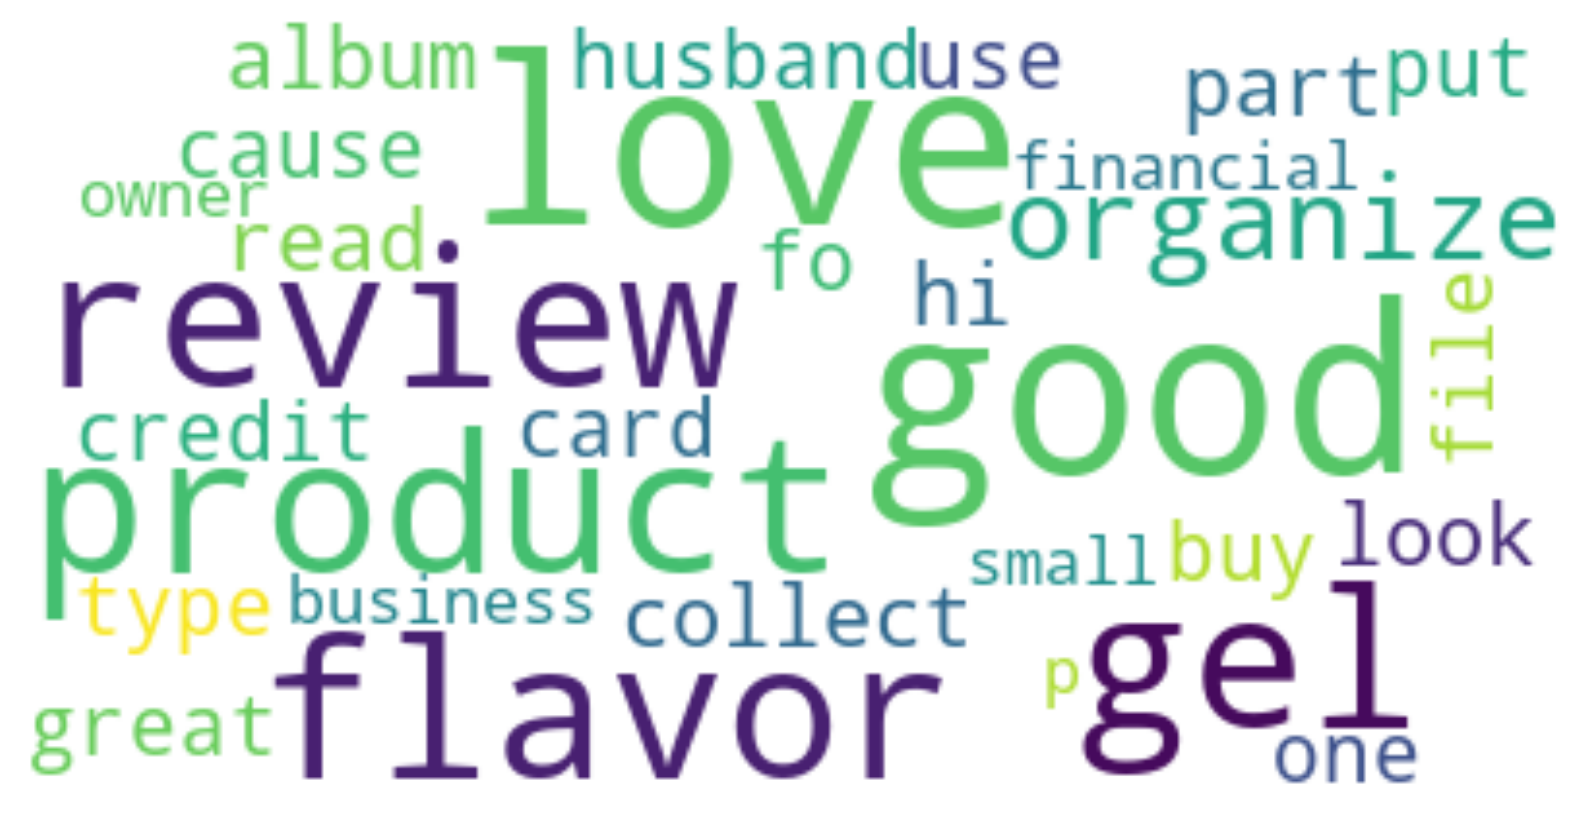

In [77]:
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30,
                      background_color="white", random_state=42,
                      stopwords=stopwords_wordcloud).generate(str(data['lemma_text']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [78]:
reviews  = data["lemma_text"].tolist()
labels = data["sentiment"].tolist()

In [79]:
print(reviews[:2])
print(labels[:2])

['I love this album its very good more to the hip hop side than her current pop sound so hype I listen to this everyday at the gym I give it 5star rating all the way her metaphor be just crazy', 'good flavor this review be collect as part of a promotion']
[1, 1]


##SPLITING THE DATASET FOR TRAINING AND VALIDATION

In [80]:
#now spliting the dataset for training and testing
training_sentences, validation_sentences, training_labels, validation_labels= train_test_split(reviews,labels, test_size=0.2)

In [81]:
#now tokenization of  the sentences  in the proper format
tokenizer  = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 59.6kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 9.03MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.20MB/s]
config.json: 100%|██████████| 483/483 [00:00<00:00, 1.24MB/s]


In [82]:
tokenizer([training_sentences[0]],truncation =True, padding  =True, max_length = 128)

{'input_ids': [[101, 19723, 24454, 2923, 11052, 9496, 6290, 6949, 2079, 6429, 2518, 2005, 2026, 3096, 6880, 2009, 2191, 2026, 3096, 5744, 16176, 1998, 4025, 2000, 14899, 2185, 10634, 3096, 2009, 2022, 6429, 1045, 2031, 2200, 4318, 3096, 1998, 1996, 11052, 9496, 6774, 7814, 1997, 1996, 6949, 2022, 2327, 17048, 2818, 1045, 2079, 2025, 2031, 4318, 8983, 5973, 1998, 2009, 2197, 2035, 2305, 2146, 19723, 24454, 2923, 6949, 2022, 2026, 5440, 4031, 2023, 3319, 2022, 8145, 2004, 2112, 1997, 1037, 4712, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [83]:
train_encodings  = tokenizer(training_sentences,
                             truncation  =True,
                             padding = True
                             )
val_encodings   = tokenizer(validation_sentences,
                            truncation =True,
                            padding  =True)


In [84]:
train_dataset  = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))
val_dataset  = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

In [85]:
#modeling  for the further running of the coding in the sentiment analysis of the reviews
model  =TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels =2)

model.safetensors: 100%|██████████| 268M/268M [00:25<00:00, 10.3MB/s] 
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pr

INITIALIZATION OF THE BERT MODEL FOR SENTIMENT ANALYSIS

In [86]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, metrics=['accuracy'])
model.fit(train_dataset.shuffle(100).batch(16),
          epochs=1,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16)) #epochs are can be more than 1 but it takes long time to execute so  We just use 1

200/200 [==============================] - 4174s 21s/step - loss: 0.3418 - accuracy: 0.8601 - val_loss: 0.3282 - val_accuracy: 0.8598


In [90]:
model.save_pretrained("/Users/ramesh/Desktop/System Recommendation/model")
tokenizer.save_pretrained("/Users/ramesh/Desktop/System Recommendation/model") 

('/Users/ramesh/Desktop/System Recommendation/model/tokenizer_config.json',
 '/Users/ramesh/Desktop/System Recommendation/model/special_tokens_map.json',
 '/Users/ramesh/Desktop/System Recommendation/model/vocab.txt',
 '/Users/ramesh/Desktop/System Recommendation/model/added_tokens.json',
 '/Users/ramesh/Desktop/System Recommendation/model/tokenizer.json')

In [35]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/Users/ramesh/Desktop/System Recommendation/model")
loaded_tokenizer= DistilBertTokenizerFast.from_pretrained("/Users/ramesh/Desktop/System Recommendation/model")

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /Users/ramesh/Desktop/System Recommendation/model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [69]:
test_sentence=" This is not good in the way that we are not able to answer the question"

def analyze_sentiment(test_sentence):
    predict_input = loaded_tokenizer.encode(test_sentence,
                                     truncation=True,
                                     padding=True,
                                     return_tensors="tf")

    tf_output = loaded_model.predict(predict_input)[0]


    tf_prediction = tf.nn.softmax(tf_output, axis=1)
    labels = [0,1]
    label = tf.argmax(tf_prediction, axis=1)
    label = label.numpy()
    return labels[label[0]]

In [71]:
#lets check one of the sentence for sentinement analysis
Text   ='Apple is the best brand in the field of the tehnology but it is too expensive as compared to other brand of technology.'
if analyze_sentiment(Text)==0:
    print("negative")
else: 
    print("Positive")
 

1/1 [==============================] - 0s 34ms/step
Positive


In [64]:
data['review_sentiment'] =data["lemma_text"].apply(analyze_sentiment)

1/1 [==============================] - 0s 46ms/step


In [73]:
data['reviews_sentiment']=data['review_sentiment'].map({'Negative': 0, 'Positive': 1})
data.head()

,brand,name,categories,reviews_username,reviews_rating,reviews_text,sentiment,lemma_text,review_sentiment,reviews_sentiment
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",joshua,5,i love this album its very good more to the hi...,1,I love this album its very good more to the hi...,Positive,1
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,5,good flavor this review was collected as part ...,1,good flavor this review be collect as part of ...,Positive,1
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",dorothy w,5,good flavor,1,good flavor,Positive,1
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",rebecca,1,i read through the reviews on here before look...,0,I read through the review on here before look ...,Negative,0
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",walker557,1,my husband bought this gel for us the gel caus...,0,my husband buy this gel for we the gel cause i...,Negative,0


In [74]:
#now we do not need  lemma data, review sentiment, rivewi rating  review user for Recommendation system do 
#our clean data for Recommnedation system  is  
data= data[['brand','name','categories','sentiment','reviews_sentiment']]
data.head()

,brand,name,categories,sentiment,reviews_sentiment
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",1,1
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",1,1
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",1,1
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",0,0
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",0,0


In [75]:
''' 
We need to use this clean data frequently in future but if we  run whole code to clean thedata it will takes long time so we gonna save the data  for future use and we will the use that
'''
data.to_csv("/Users/ramesh/Desktop/System Recommendation/model/clean_data.csv",index =False)

In [4]:
#we goona load the clean data for using it continuously 
clean_data  =  pd.read_csv("/Users/ramesh/Desktop/System Recommendation/model/clean_data.csv")


In [5]:
clean_data.head(20)

,brand,name,categories,sentiment,reviews_sentiment
0,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",1,1
1,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",1,1
2,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",1,1
3,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",0,0
4,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",0,0
5,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",0,1
6,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",0,0
7,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",0,0
8,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",0,0
9,K-Y,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",0,1


In [6]:
clean_data['name'].unique()

array(['Pink Friday: Roman Reloaded Re-Up (w/dvd)',
       'Lundberg Organic Cinnamon Toast Rice Cakes',
       'K-Y Love Sensuality Pleasure Gel',
       'J.R. Watkins Hand Cream, Lemon Cream',
       'Ambi Complexion Cleansing Bar',
       "Johnson's Baby Bubble Bath and Wash, 15oz",
       'Olay Regenerist Deep Hydration Regenerating Cream',
       'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       'Heinz Tomato Ketchup, 38oz',
       'Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count',
       'Pantene Color Preserve Volume Shampoo, 25.4oz',
       'Aussie Aussome Volume Shampoo, 13.5 Oz',
       "Cars Toon: Mater's Tall Tales", 'CeraVe SA Renewing Cream',
       'Solo Foods Almond Paste',
       'Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count',
       'Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler',
       'Pearhead Id Bracelet Frame',
       'Craft Punch Giga Scallop Circle 45 24687534 To 334',
       'Neutrogena